In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
import tensorflow as tf

In [2]:
df_train = pd.read_csv('/content/drive/MyDrive/Data Analytics Boot Camp/Project_4/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Data Analytics Boot Camp/Project_4/test.csv')

In [3]:
df_train2= df_train.copy().drop(['Transported'],axis=1)

df_train2.shape


(8693, 13)

In [4]:
data = pd.concat([df_train2, df_test], axis = 0).reset_index(drop = True)

data.shape

(12970, 13)

In [ ]:
# Data from the Cabin
data[["CabinDeck", "CabinNo.", "CabinSide"]] = data["Cabin"].str.split('/', expand = True)

In [ ]:
data["Group"] = data["PassengerId"].str.split('_', expand = True)[0]

In [ ]:
No_People_In_PassengerGroup = data.groupby('Group').aggregate({'PassengerId': 'size'}).reset_index()
No_People_In_PassengerGroup = No_People_In_PassengerGroup.rename(columns = {"PassengerId": "Group_size"})

data = data.merge(No_People_In_PassengerGroup[["Group", "Group_size"]], how = 'left', on = ['Group'])


In [ ]:
data["Last_name"] = data["Name"].str.split(' ', expand = True)[1]

In [ ]:
Family_size = data.groupby('Last_name').aggregate({'PassengerId': 'size'}).reset_index()
Family_size = Family_size.rename(columns = {"PassengerId": "Family_size"})

data = data.merge(Family_size[["Last_name", "Family_size"]], how = 'left', on = ['Last_name'])

In [ ]:
# Data from the group
No_People_In_PassengerGroup["IsAlone"] = No_People_In_PassengerGroup["Group_size"].apply(lambda x: False if x > 1 else True)
data = data.merge(No_People_In_PassengerGroup[["Group", "IsAlone"]], how = 'left', on = ['Group'])

In [ ]:
# Filling NaNs based on Age
def fill_nans_by_age_and_cryosleep(df):
    df["RoomService"] = np.where((df["Age"] < 13) | (df["CryoSleep"] == True), 0, df["RoomService"])
    df["FoodCourt"] = np.where((df["Age"] < 13) | (df["CryoSleep"] == True), 0, df["FoodCourt"])
    df["ShoppingMall"] = np.where((df["Age"] < 13) | (df["CryoSleep"] == True), 0, df["ShoppingMall"])
    df["Spa"] = np.where((df["Age"] < 13) | (df["CryoSleep"] == True), 0, df["Spa"])
    df["VRDeck"] = np.where((df["Age"] < 13) | (df["CryoSleep"] == True), 0, df["VRDeck"])

    return df

data = fill_nans_by_age_and_cryosleep(data)


In [ ]:
data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,VRDeck,Name,CabinDeck,CabinNo.,CabinSide,Group,Group_size,Last_name,Family_size,IsAlone
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,0.0,Maham Ofracculy,B,0,P,0001,1,Ofracculy,3.0,True
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,44.0,Juanna Vines,F,0,S,0002,1,Vines,4.0,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,49.0,Altark Susent,A,0,S,0003,2,Susent,7.0,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,193.0,Solam Susent,A,0,S,0003,2,Susent,7.0,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,2.0,Willy Santantines,F,1,S,0004,1,Santantines,9.0,True


In [ ]:
data.isnull().sum().sort_values(ascending=False)

CryoSleep       310
Cabin           299
CabinSide       299
CabinNo.        299
CabinDeck       299
VIP             296
Family_size     294
Name            294
Last_name       294
HomePlanet      288
Destination     274
Age             270
FoodCourt       171
Spa             166
ShoppingMall    163
RoomService     162
VRDeck          150
PassengerId       0
Group_size        0
Group             0
IsAlone           0
dtype: int64

In [ ]:
data2 = data.copy()

In [ ]:
GHP_gb = data2.groupby(['Group','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
GHP_gb

HomePlanet,Earth,Europa,Mars
Group,,,
0001,0.0,1.0,0.0
0002,1.0,0.0,0.0
0003,0.0,2.0,0.0
0004,1.0,0.0,0.0
0005,1.0,0.0,0.0
...,...,...,...
9276,0.0,1.0,0.0
9277,1.0,0.0,0.0
9278,1.0,0.0,0.0


In [ ]:
((GHP_gb>0).sum(axis=1)>1).value_counts()

# Each Group is from the same planet


False    9124
dtype: int64

In [ ]:
data2[data2['HomePlanet'].isna()]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,VRDeck,Name,CabinDeck,CabinNo.,CabinSide,Group,Group_size,Last_name,Family_size,IsAlone
59,0064_02,NaN,True,E/3/S,TRAPPIST-1e,33.0,False,0.0,0.0,0.0,...,0.0,Colatz Keen,E,3,S,0064,2,Keen,6.0,False
113,0119_01,NaN,False,A/0/P,TRAPPIST-1e,39.0,False,0.0,2344.0,0.0,...,6898.0,Batan Coning,A,0,P,0119,2,Coning,5.0,False
186,0210_01,NaN,True,D/6/P,55 Cancri e,24.0,False,0.0,0.0,0.0,...,0.0,Arraid Inicont,D,6,P,0210,1,Inicont,3.0,True
225,0242_01,NaN,False,F/46/S,TRAPPIST-1e,18.0,False,313.0,1.0,691.0,...,0.0,Almone Sté,F,46,S,0242,1,Sté,3.0,True
234,0251_01,NaN,True,C/11/S,55 Cancri e,54.0,False,0.0,0.0,0.0,...,0.0,Diphah Amsive,C,11,S,0251,1,Amsive,1.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12650,8621_01,NaN,False,E/552/P,TRAPPIST-1e,19.0,False,4.0,0.0,1604.0,...,0.0,Vanley Simmonders,E,552,P,8621,1,Simmonders,8.0,True
12673,8678_01,NaN,True,G/1399/S,55 Cancri e,9.0,False,0.0,0.0,0.0,...,0.0,Eilan Kellson,G,1399,S,8678,2,Kellson,8.0,False
12725,8775_01,NaN,True,D/275/P,TRAPPIST-1e,40.0,False,0.0,0.0,0.0,...,0.0,Raston Maltorted,D,275,P,8775,1,Maltorted,2.0,True
12852,9025_01,NaN,False,G/1454/S,TRAPPIST-1e,42.0,False,0.0,0.0,28.0,...,0.0,Ale Whitersone,G,1454,S,9025,2,Whitersone,8.0,False


In [ ]:

GHP_index=data2[data2['HomePlanet'].isna()][(data2[data2['HomePlanet'].isna()]['Group']).isin(GHP_gb.index)].index
GHP_index

Int64Index([   59,   113,   405,   407,   438,   471,   501,   505,   524,
              568,
            ...
            11682, 11876, 12124, 12149, 12158, 12250, 12590, 12673, 12852,
            12906],
           dtype='int64', length=131)

In [ ]:
data2.loc[GHP_index,'HomePlanet']=data2.iloc[GHP_index,:]['Group'].map(lambda x: GHP_gb.idxmax(axis=1)[x])

In [ ]:
data2[data2['HomePlanet'].isna()]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,VRDeck,Name,CabinDeck,CabinNo.,CabinSide,Group,Group_size,Last_name,Family_size,IsAlone
186,0210_01,NaN,True,D/6/P,55 Cancri e,24.0,False,0.0,0.0,0.0,...,0.0,Arraid Inicont,D,6,P,0210,1,Inicont,3.0,True
225,0242_01,NaN,False,F/46/S,TRAPPIST-1e,18.0,False,313.0,1.0,691.0,...,0.0,Almone Sté,F,46,S,0242,1,Sté,3.0,True
234,0251_01,NaN,True,C/11/S,55 Cancri e,54.0,False,0.0,0.0,0.0,...,0.0,Diphah Amsive,C,11,S,0251,1,Amsive,1.0,True
274,0303_01,NaN,True,G/41/S,TRAPPIST-1e,23.0,False,0.0,0.0,0.0,...,0.0,Oraryn Kirklander,G,41,S,0303,1,Kirklander,5.0,True
286,0315_01,NaN,True,G/42/S,PSO J318.5-22,35.0,False,0.0,0.0,0.0,...,0.0,Adriet Valezaley,G,42,S,0315,1,Valezaley,11.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12542,8417_01,NaN,False,F/1617/S,TRAPPIST-1e,43.0,False,0.0,0.0,775.0,...,93.0,Luzel Bertsontry,F,1617,S,8417,1,Bertsontry,9.0,True
12551,8435_01,NaN,NaN,F/1730/P,TRAPPIST-1e,19.0,False,162.0,11.0,0.0,...,1216.0,NaN,F,1730,P,8435,1,NaN,NaN,True
12638,8576_01,NaN,True,C/322/S,55 Cancri e,25.0,False,0.0,0.0,0.0,...,0.0,Skatzn Catbel,C,322,S,8576,1,Catbel,2.0,True
12650,8621_01,NaN,False,E/552/P,TRAPPIST-1e,19.0,False,4.0,0.0,1604.0,...,0.0,Vanley Simmonders,E,552,P,8621,1,Simmonders,8.0,True


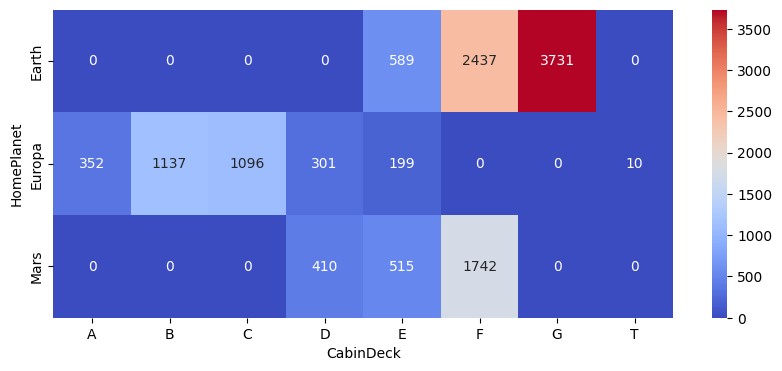

In [ ]:
# Distribution of CabinDeck and HomePlanet
CDHP_gb =data2.groupby(['CabinDeck','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)

# Heatmap of missing values
plt.figure(figsize=(10,4))
sns.heatmap(CDHP_gb.T, annot=True, fmt='g', cmap='coolwarm')
plt.show()

In [ ]:
# Decks A, B, C or T came from Europa
data2.loc[(data2['HomePlanet'].isna()) & (data2['CabinDeck'].isin(['A', 'B', 'C', 'T'])), 'HomePlanet']='Europa'

# Deck G came from Earth
data2.loc[(data2['HomePlanet'].isna()) & (data2['CabinDeck']=='G'), 'HomePlanet']='Earth'

In [ ]:
data2[data2['HomePlanet'].isna()]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,VRDeck,Name,CabinDeck,CabinNo.,CabinSide,Group,Group_size,Last_name,Family_size,IsAlone
186,0210_01,NaN,True,D/6/P,55 Cancri e,24.0,False,0.0,0.0,0.0,...,0.0,Arraid Inicont,D,6,P,0210,1,Inicont,3.0,True
225,0242_01,NaN,False,F/46/S,TRAPPIST-1e,18.0,False,313.0,1.0,691.0,...,0.0,Almone Sté,F,46,S,0242,1,Sté,3.0,True
291,0321_01,NaN,False,F/61/S,TRAPPIST-1e,59.0,True,1018.0,0.0,209.0,...,0.0,Quites Bache,F,61,S,0321,1,Bache,5.0,True
365,0402_01,NaN,True,D/15/S,55 Cancri e,32.0,True,0.0,0.0,0.0,...,0.0,Teron Sageng,D,15,S,0402,1,Sageng,12.0,True
481,0518_01,NaN,True,F/92/S,TRAPPIST-1e,35.0,False,0.0,0.0,0.0,...,0.0,Soyos Parta,F,92,S,0518,1,Parta,5.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12347,7961_01,NaN,False,D/231/S,TRAPPIST-1e,39.0,False,1905.0,0.0,479.0,...,0.0,Quants Burle,D,231,S,7961,1,Burle,6.0,True
12542,8417_01,NaN,False,F/1617/S,TRAPPIST-1e,43.0,False,0.0,0.0,775.0,...,93.0,Luzel Bertsontry,F,1617,S,8417,1,Bertsontry,9.0,True
12551,8435_01,NaN,NaN,F/1730/P,TRAPPIST-1e,19.0,False,162.0,11.0,0.0,...,1216.0,NaN,F,1730,P,8435,1,NaN,NaN,True
12650,8621_01,NaN,False,E/552/P,TRAPPIST-1e,19.0,False,4.0,0.0,1604.0,...,0.0,Vanley Simmonders,E,552,P,8621,1,Simmonders,8.0,True


In [ ]:
LNHP_gb=data2.groupby(['Last_name','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
LNHP_gb

HomePlanet,Earth,Europa,Mars
Last_name,,,
Acobson,5.0,0.0,0.0
Acobsond,8.0,0.0,0.0
Adavisons,10.0,0.0,0.0
Adkinson,4.0,0.0,0.0
Admingried,0.0,4.0,0.0
...,...,...,...
Wynneyerson,2.0,0.0,0.0
Yanton,8.0,0.0,0.0
Yatters,8.0,0.0,0.0


In [ ]:
((LNHP_gb>0).sum(axis=1)>1).value_counts()

# One Home Planet per Last Name

False    2402
dtype: int64

In [ ]:
LNHP_index=data2[data2['HomePlanet'].isna()][(data2[data2['HomePlanet'].isna()]['Last_name']).isin(LNHP_gb.index)].index

data2.loc[LNHP_index,'HomePlanet']=data2.iloc[LNHP_index,:]['Last_name'].map(lambda x: LNHP_gb.idxmax(axis=1)[x])

In [ ]:
data2[data2['HomePlanet'].isna()]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,VRDeck,Name,CabinDeck,CabinNo.,CabinSide,Group,Group_size,Last_name,Family_size,IsAlone
2274,2443_01,NaN,False,D/72/P,TRAPPIST-1e,31.0,False,1458.0,421.0,76.0,...,0.0,NaN,D,72,P,2443,1,NaN,NaN,True
2631,2817_01,NaN,False,F/584/P,TRAPPIST-1e,25.0,False,237.0,0.0,910.0,...,12.0,Sealfs Sutty,F,584,P,2817,1,Sutty,1.0,True
3091,3331_01,NaN,False,F/631/S,TRAPPIST-1e,40.0,False,666.0,4.0,83.0,...,50.0,NaN,F,631,S,3331,1,NaN,NaN,True
4548,4840_01,NaN,True,F/915/S,TRAPPIST-1e,36.0,False,0.0,0.0,0.0,...,0.0,NaN,F,915,S,4840,1,NaN,NaN,True
5762,6108_01,NaN,False,F/1166/S,TRAPPIST-1e,13.0,False,206.0,28.0,0.0,...,629.0,NaN,F,1166,S,6108,1,NaN,NaN,True
8969,0616_01,NaN,False,E/40/S,TRAPPIST-1e,31.0,False,0.0,428.0,NaN,...,1025.0,Arkaban Spriney,E,40,S,0616,1,Spriney,1.0,True
10583,4052_01,NaN,False,D/136/P,TRAPPIST-1e,26.0,False,6.0,5903.0,0.0,...,72.0,Ankabih Coneveseng,D,136,P,4052,1,Coneveseng,1.0,True
11913,7065_01,NaN,True,E/471/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,...,0.0,Zedares Maltorted,E,471,S,7065,1,Maltorted,2.0,True
12551,8435_01,NaN,NaN,F/1730/P,TRAPPIST-1e,19.0,False,162.0,11.0,0.0,...,1216.0,NaN,F,1730,P,8435,1,NaN,NaN,True
12725,8775_01,NaN,True,D/275/P,TRAPPIST-1e,40.0,False,0.0,0.0,0.0,...,0.0,Raston Maltorted,D,275,P,8775,1,Maltorted,2.0,True


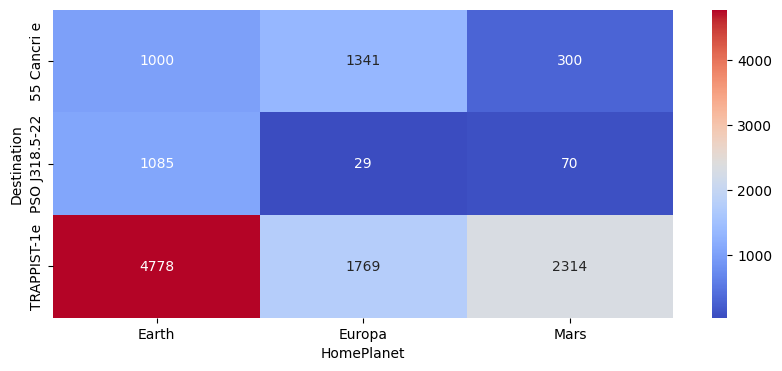

In [ ]:
# Joint distribution of HomePlanet and Destination
HPD_gb=data2.groupby(['HomePlanet','Destination'])['Destination'].size().unstack().fillna(0)

# Heatmap of missing values
plt.figure(figsize=(10,4))
sns.heatmap(HPD_gb.T, annot=True, fmt='g', cmap='coolwarm')
plt.show()

In [ ]:
data2.loc[(data2['HomePlanet'].isna()) & ~(data2['CabinDeck']=='D'), 'HomePlanet']='Earth'
data2.loc[(data2['HomePlanet'].isna()) & (data2['CabinDeck']=='D'), 'HomePlanet']='Mars'

In [ ]:
data2.isnull().sum().sort_values(ascending=False)

CryoSleep       310
Cabin           299
CabinSide       299
CabinNo.        299
CabinDeck       299
VIP             296
Last_name       294
Name            294
Family_size     294
Destination     274
Age             270
FoodCourt       171
Spa             166
ShoppingMall    163
RoomService     162
VRDeck          150
Group_size        0
PassengerId       0
Group             0
HomePlanet        0
IsAlone           0
dtype: int64

In [ ]:
luxury_feats = ['RoomService','Spa','VRDeck']
regular_feats = ['FoodCourt','ShoppingMall']

In [ ]:
data2['Luxury_exp'] = data2[luxury_feats].sum(axis=1)
data2['Regular_exp'] = data2[regular_feats].sum(axis=1)
data2['Total_exp'] = data2[['Luxury_exp','Regular_exp']].sum(axis=1)

data2.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,CabinNo.,CabinSide,Group,Group_size,Last_name,Family_size,IsAlone,Luxury_exp,Regular_exp,Total_exp
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,0,P,0001,1,Ofracculy,3.0,True,0.0,0.0,0.0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,0,S,0002,1,Vines,4.0,True,702.0,34.0,736.0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,0,S,0003,2,Susent,7.0,False,6807.0,3576.0,10383.0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,0,S,0003,2,Susent,7.0,False,3522.0,1654.0,5176.0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,1,S,0004,1,Santantines,9.0,True,870.0,221.0,1091.0


## Correr desde aqui para Cryo Data

In [ ]:
cryo_data = data2.copy()

In [ ]:
cryo_data = cryo_data.drop(['CabinNo.', 'Group', 'Name', 'Cabin', 'PassengerId','Last_name', 'Luxury_exp' ,'Regular_exp'],axis =1)


In [ ]:
cryo_data.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinDeck,CabinSide,Group_size,Family_size,IsAlone,Total_exp
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,B,P,1,3.0,True,0.0
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,F,S,1,4.0,True,736.0
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,A,S,2,7.0,False,10383.0
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,A,S,2,7.0,False,5176.0
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,F,S,1,9.0,True,1091.0


In [ ]:
missing_categorical_columns = cryo_data.select_dtypes(include=['object','bool']).isna().sum() > 0
missing_categorical_columns = list(missing_categorical_columns[missing_categorical_columns].index)
missing_categorical_columns.remove('CryoSleep')
missing_categorical_columns

['Destination', 'VIP', 'CabinDeck', 'CabinSide']

In [ ]:
for col in missing_categorical_columns:
    cryo_data[col] = cryo_data[col].fillna(cryo_data[col].mode()[0])

In [ ]:
cryo_data.isnull().sum().sort_values(ascending=False)

CryoSleep       310
Family_size     294
Age             270
FoodCourt       171
Spa             166
ShoppingMall    163
RoomService     162
VRDeck          150
HomePlanet        0
Destination       0
VIP               0
CabinDeck         0
CabinSide         0
Group_size        0
IsAlone           0
Total_exp         0
dtype: int64

In [ ]:
missing_numerical_columns = cryo_data.select_dtypes(include=['int','float64']).isna().sum() > 0
missing_numerical_columns = list(missing_numerical_columns[missing_numerical_columns].index)

print(missing_numerical_columns)

for col in missing_numerical_columns:
    cryo_data[col] = cryo_data[col].fillna(cryo_data[col].mean())

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Family_size']


In [ ]:
cryo_data.isnull().sum().sort_values(ascending=False)

CryoSleep       310
HomePlanet        0
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
CabinDeck         0
CabinSide         0
Group_size        0
Family_size       0
IsAlone           0
Total_exp         0
dtype: int64

In [ ]:
null_cryo = cryo_data[cryo_data['CryoSleep'].isnull()]

In [ ]:
has_cryo = cryo_data[cryo_data['CryoSleep'].notnull()]

In [ ]:
has_cryo.isnull().sum().sort_values(ascending=False)

HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
CabinDeck       0
CabinSide       0
Group_size      0
Family_size     0
IsAlone         0
Total_exp       0
dtype: int64

In [ ]:
# Separate the target and the features variables
y = has_cryo["CryoSleep"]
X = has_cryo.drop(columns="CryoSleep")


In [ ]:
numerical_columns = X.select_dtypes(include=['int','float64']).columns
categorical_columns = X.select_dtypes(include=['object','boolean']).columns

print(numerical_columns)
print(categorical_columns)

Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Group_size', 'Family_size', 'Total_exp'],
      dtype='object')
Index(['HomePlanet', 'Destination', 'VIP', 'CabinDeck', 'CabinSide',
       'IsAlone'],
      dtype='object')


In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('nominal', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
        ('numeric', StandardScaler(), numerical_columns)
        ])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

In [ ]:
X_train = preprocessor.fit_transform(X_train)
X_test  = preprocessor.transform(X_test)

In [ ]:
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.709991,-0.346252,-0.283074,-0.298044,-0.278554,-0.259010,-0.011691,-1.508206,-0.508229
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.016645,2.217769,-0.281844,0.124948,-0.137953,-0.259010,-0.644878,-0.639196,0.215709
2,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.228313,-0.346252,-0.138465,-0.298044,0.151414,-0.259010,-0.644878,0.519485,-0.260032
3,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,-1.465033,-0.346252,-0.283074,-0.298044,-0.278554,-0.259010,-0.644878,1.678166,-0.508229
4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,-0.336135,0.785973,-0.102774,0.228075,-0.278554,-0.259010,-0.011691,0.519485,-0.042290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10123,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,-0.124467,0.368109,-0.283074,-0.165204,-0.276740,0.485553,-0.644878,-0.928866,-0.009034
10124,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,2.062772,-0.346252,-0.283074,-0.298044,-0.278554,-0.259010,0.621496,1.388496,-0.508229
10125,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.933874,-0.346252,-0.283074,-0.298044,-0.278554,-0.259010,-0.644878,-0.059855,-0.508229
10126,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.000556,-0.346252,-0.283074,-0.298044,-0.278554,-0.259010,-0.644878,-0.639196,-0.508229


In [ ]:
X_train.shape

(10128, 29)

In [ ]:
y_train

6518     False
8784     False
4654     False
8319     False
5899     False
         ...  
11164    False
591       True
5992      True
2496      True
7374      True
Name: CryoSleep, Length: 10128, dtype: object

In [ ]:
y_train = y_train.astype(int)
y_train

6518     0
8784     0
4654     0
8319     0
5899     0
        ..
11164    0
591      1
5992     1
2496     1
7374     1
Name: CryoSleep, Length: 10128, dtype: int64

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(units=80, activation='relu', input_shape=(X_train.shape[1],)),
  tf.keras.layers.Dense(units=60, activation='relu'),
    tf.keras.layers.Dense(units=50, activation='relu'),
  tf.keras.layers.Dense(units=1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 80)                2400      
                                                                 
 dense_13 (Dense)            (None, 60)                4860      
                                                                 
 dense_14 (Dense)            (None, 50)                3050      
                                                                 
 dense_15 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10361 (40.47 KB)
Trainable params: 10361 (40.47 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, epochs=100, verbose=True)

Epoch 1/100
317/317 [==============================] - 2s 3ms/step - loss: 0.2230 - accuracy: 0.8936
Epoch 2/100
317/317 [==============================] - 1s 3ms/step - loss: 0.1262 - accuracy: 0.9421
Epoch 3/100
317/317 [==============================] - 1s 3ms/step - loss: 0.1185 - accuracy: 0.9435
Epoch 4/100
317/317 [==============================] - 1s 4ms/step - loss: 0.1128 - accuracy: 0.9453
Epoch 5/100
317/317 [==============================] - 2s 5ms/step - loss: 0.1114 - accuracy: 0.9472
Epoch 6/100
317/317 [==============================] - 2s 6ms/step - loss: 0.1089 - accuracy: 0.9468
Epoch 7/100
317/317 [==============================] - 1s 3ms/step - loss: 0.1076 - accuracy: 0.9456
Epoch 8/100
317/317 [==============================] - 1s 3ms/step - loss: 0.1051 - accuracy: 0.9471
Epoch 9/100
317/317 [==============================] - 1s 3ms/step - loss: 0.1019 - accuracy: 0.9476
Epoch 10/100
317/317 [==============================] - 1s 3ms/step - loss: 0.1015 - accura

In [ ]:
y_test = y_test.astype(int)
y_test

2965     0
11871    0
12312    1
8606     0
4093     0
        ..
11380    0
10044    0
5830     1
601      1
9901     1
Name: CryoSleep, Length: 2532, dtype: int64

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')

80/80 [==============================] - 1s 4ms/step - loss: 0.1666 - accuracy: 0.9419
Test accuracy: 0.9419431090354919, Test loss: 0.16664105653762817


In [ ]:
null_cryo.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinDeck,CabinSide,Group_size,Family_size,IsAlone,Total_exp
92,Earth,NaN,TRAPPIST-1e,2.0,False,0.0,0.0,0.0,0.0,0.000000,G,P,2,4.0,False,0.0
98,Earth,NaN,TRAPPIST-1e,27.0,False,0.0,0.0,570.0,2.0,131.000000,F,P,1,9.0,True,703.0
104,Europa,NaN,TRAPPIST-1e,40.0,False,0.0,331.0,0.0,0.0,1687.000000,B,P,4,2.0,False,2018.0
111,Mars,NaN,TRAPPIST-1e,26.0,False,0.0,0.0,0.0,0.0,303.965679,F,P,1,5.0,True,0.0
152,Earth,NaN,TRAPPIST-1e,58.0,False,0.0,985.0,0.0,5.0,0.000000,E,S,1,4.0,True,990.0


In [ ]:
X_pred = null_cryo.drop(columns="CryoSleep")
X_pred

,HomePlanet,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinDeck,CabinSide,Group_size,Family_size,IsAlone,Total_exp
92,Earth,TRAPPIST-1e,2.0,False,0.0,0.0,0.000000,0.0,0.000000,G,P,2,4.0,False,0.0
98,Earth,TRAPPIST-1e,27.0,False,0.0,0.0,570.000000,2.0,131.000000,F,P,1,9.0,True,703.0
104,Europa,TRAPPIST-1e,40.0,False,0.0,331.0,0.000000,0.0,1687.000000,B,P,4,2.0,False,2018.0
111,Mars,TRAPPIST-1e,26.0,False,0.0,0.0,0.000000,0.0,303.965679,F,P,1,5.0,True,0.0
152,Earth,TRAPPIST-1e,58.0,False,0.0,985.0,0.000000,5.0,0.000000,E,S,1,4.0,True,990.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12688,Mars,55 Cancri e,20.0,False,0.0,0.0,0.000000,0.0,0.000000,F,P,1,4.0,True,0.0
12801,Europa,TRAPPIST-1e,27.0,False,0.0,2182.0,7.000000,2582.0,19.000000,C,P,6,8.0,False,4790.0
12902,Europa,TRAPPIST-1e,41.0,False,0.0,1998.0,0.000000,1023.0,867.000000,F,S,1,4.0,True,3888.0
12923,Earth,TRAPPIST-1e,14.0,False,0.0,0.0,172.953073,1377.0,29.000000,F,S,1,16.0,True,1406.0


In [ ]:
X_pred = preprocessor.transform(X_pred)

In [ ]:
pd.DataFrame(X_pred)

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,-1.888369,-0.346252,-0.283074,-0.298044,-0.278554,-0.259010,-0.011691,-0.928866,-0.508229
1,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,-0.124467,-0.346252,-0.283074,0.698260,-0.276740,-0.148548,-0.644878,0.519485,-0.262132
2,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.792762,-0.346252,-0.079391,-0.298044,-0.278554,1.163502,1.254683,-1.508206,0.198206
3,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,-0.195023,-0.346252,-0.283074,-0.298044,-0.278554,-0.002700,-0.644878,-0.639196,-0.508229
4,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,2.062772,-0.346252,0.323053,-0.298044,-0.274019,-0.259010,-0.644878,-0.928866,-0.161663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,-0.618360,-0.346252,-0.283074,-0.298044,-0.278554,-0.259010,-0.644878,-0.928866,-0.508229
306,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,-0.124467,-0.346252,1.059636,-0.285809,2.063592,-0.242989,2.521056,0.229815,1.168591
307,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.863318,-0.346252,0.946411,-0.298044,0.649415,0.472062,-0.644878,-0.928866,0.852831
308,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,-1.041696,-0.346252,-0.283074,0.004261,0.970530,-0.234557,-0.644878,2.547176,-0.016035


In [ ]:
predictions = (model.predict(X_pred)[:,0]>0.5).astype(bool)

10/10 [==============================] - 0s 2ms/step


In [ ]:
pred_df = pd.DataFrame(predictions)

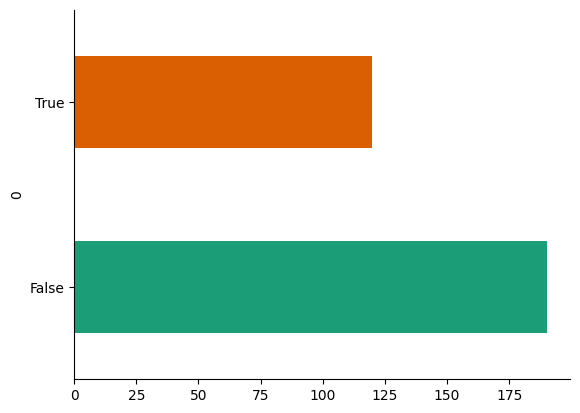

In [ ]:

pred_df.groupby(0).size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
null_cryo['CryoSleep'] = predictions
null_cryo

<ipython-input-109-6acac6c52771>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  null_cryo['CryoSleep'] = predictions


,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinDeck,CabinSide,Group_size,Family_size,IsAlone,Total_exp
92,Earth,True,TRAPPIST-1e,2.0,False,0.0,0.0,0.000000,0.0,0.000000,G,P,2,4.0,False,0.0
98,Earth,False,TRAPPIST-1e,27.0,False,0.0,0.0,570.000000,2.0,131.000000,F,P,1,9.0,True,703.0
104,Europa,False,TRAPPIST-1e,40.0,False,0.0,331.0,0.000000,0.0,1687.000000,B,P,4,2.0,False,2018.0
111,Mars,True,TRAPPIST-1e,26.0,False,0.0,0.0,0.000000,0.0,303.965679,F,P,1,5.0,True,0.0
152,Earth,False,TRAPPIST-1e,58.0,False,0.0,985.0,0.000000,5.0,0.000000,E,S,1,4.0,True,990.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12688,Mars,True,55 Cancri e,20.0,False,0.0,0.0,0.000000,0.0,0.000000,F,P,1,4.0,True,0.0
12801,Europa,False,TRAPPIST-1e,27.0,False,0.0,2182.0,7.000000,2582.0,19.000000,C,P,6,8.0,False,4790.0
12902,Europa,False,TRAPPIST-1e,41.0,False,0.0,1998.0,0.000000,1023.0,867.000000,F,S,1,4.0,True,3888.0
12923,Earth,False,TRAPPIST-1e,14.0,False,0.0,0.0,172.953073,1377.0,29.000000,F,S,1,16.0,True,1406.0


In [ ]:
data2.isnull().sum().sort_values(ascending=False)

CryoSleep       310
Cabin           299
CabinSide       299
CabinNo.        299
CabinDeck       299
VIP             296
Name            294
Family_size     294
Last_name       294
Destination     274
Age             270
FoodCourt       171
Spa             166
ShoppingMall    163
RoomService     162
VRDeck          150
Regular_exp       0
Luxury_exp        0
IsAlone           0
PassengerId       0
Group_size        0
Group             0
HomePlanet        0
Total_exp         0
dtype: int64

In [ ]:
datam = data2.copy()

In [ ]:
datam['CryoSleep'] = datam['CryoSleep'].fillna(null_cryo['CryoSleep'])




In [ ]:
datam.isnull().sum().sort_values(ascending=False)

CabinSide       299
Cabin           299
CabinNo.        299
CabinDeck       299
VIP             296
Name            294
Last_name       294
Family_size     294
Destination     274
Age             270
FoodCourt       171
Spa             166
ShoppingMall    163
RoomService     162
VRDeck          150
Luxury_exp        0
Regular_exp       0
IsAlone           0
PassengerId       0
Group_size        0
Group             0
HomePlanet        0
CryoSleep         0
Total_exp         0
dtype: int64

In [ ]:
datam = fill_nans_by_age_and_cryosleep(datam)

In [ ]:
datam.isnull().sum().sort_values(ascending=False)

CabinSide       299
Cabin           299
CabinNo.        299
CabinDeck       299
VIP             296
Name            294
Last_name       294
Family_size     294
Destination     274
Age             270
FoodCourt       171
Spa             164
RoomService     162
ShoppingMall    161
VRDeck          149
Luxury_exp        0
Regular_exp       0
IsAlone           0
PassengerId       0
Group_size        0
Group             0
HomePlanet        0
CryoSleep         0
Total_exp         0
dtype: int64

In [ ]:
datam.groupby('CryoSleep').aggregate({'Total_exp': 'sum','PassengerId': 'count'})

,Total_exp,PassengerId
CryoSleep,,
False,18588877.0,8269
True,0.0,4701


## Destination

In [ ]:
destination_data = datam.copy()

In [ ]:
destination_data = destination_data.drop(['CabinNo.', 'Group', 'Name', 'Cabin', 'PassengerId','Last_name'],axis =1)
destination_data = destination_data.drop(luxury_feats , axis =1 )
destination_data = destination_data.drop(regular_feats , axis =1 )

destination_data.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,CabinDeck,CabinSide,Group_size,Family_size,IsAlone,Luxury_exp,Regular_exp,Total_exp
0,Europa,False,TRAPPIST-1e,39.0,False,B,P,1,3.0,True,0.0,0.0,0.0
1,Earth,False,TRAPPIST-1e,24.0,False,F,S,1,4.0,True,702.0,34.0,736.0
2,Europa,False,TRAPPIST-1e,58.0,True,A,S,2,7.0,False,6807.0,3576.0,10383.0
3,Europa,False,TRAPPIST-1e,33.0,False,A,S,2,7.0,False,3522.0,1654.0,5176.0
4,Earth,False,TRAPPIST-1e,16.0,False,F,S,1,9.0,True,870.0,221.0,1091.0


In [ ]:
missing_categorical_columns = destination_data.select_dtypes(include=['object','bool']).isna().sum() > 0
missing_categorical_columns = list(missing_categorical_columns[missing_categorical_columns].index)
missing_categorical_columns.remove('Destination')

print(f'imputed columns: {missing_categorical_columns}')

for col in missing_categorical_columns:
    destination_data[col] = destination_data[col].fillna(destination_data[col].mode()[0])

imputed columns: ['VIP', 'CabinDeck', 'CabinSide']


In [ ]:
missing_numerical_columns = destination_data.select_dtypes(include=['int','float64']).isna().sum() > 0
missing_numerical_columns = list(missing_numerical_columns[missing_numerical_columns].index)

print(missing_numerical_columns)

for col in missing_numerical_columns:
    destination_data[col] = destination_data[col].fillna(destination_data[col].mean())

['Age', 'Family_size']


In [ ]:
destination_data.isnull().sum().sort_values(ascending=False)

Destination    274
HomePlanet       0
CryoSleep        0
Age              0
VIP              0
CabinDeck        0
CabinSide        0
Group_size       0
Family_size      0
IsAlone          0
Luxury_exp       0
Regular_exp      0
Total_exp        0
dtype: int64

In [ ]:
null_dest = destination_data[destination_data['Destination'].isnull()]
has_dest = destination_data[destination_data['Destination'].notnull()]


In [ ]:
has_dest.isnull().sum().sort_values(ascending=False)

HomePlanet     0
CryoSleep      0
Destination    0
Age            0
VIP            0
CabinDeck      0
CabinSide      0
Group_size     0
Family_size    0
IsAlone        0
Luxury_exp     0
Regular_exp    0
Total_exp      0
dtype: int64

In [ ]:
# Separate the target and the features variables
y = has_dest["Destination"]
X = has_dest.drop(columns="Destination")

In [ ]:
X

,HomePlanet,CryoSleep,Age,VIP,CabinDeck,CabinSide,Group_size,Family_size,IsAlone,Luxury_exp,Regular_exp,Total_exp
0,Europa,False,39.000000,False,B,P,1,3.0,True,0.0,0.0,0.0
1,Earth,False,24.000000,False,F,S,1,4.0,True,702.0,34.0,736.0
2,Europa,False,58.000000,True,A,S,2,7.0,False,6807.0,3576.0,10383.0
3,Europa,False,33.000000,False,A,S,2,7.0,False,3522.0,1654.0,5176.0
4,Earth,False,16.000000,False,F,S,1,9.0,True,870.0,221.0,1091.0
...,...,...,...,...,...,...,...,...,...,...,...,...
12964,Earth,False,40.000000,False,F,S,2,10.0,False,3.0,865.0,868.0
12965,Earth,True,34.000000,False,G,S,2,10.0,False,0.0,0.0,0.0
12966,Earth,False,42.000000,False,F,S,1,6.0,True,154.0,864.0,1018.0
12967,Mars,True,28.771969,False,D,P,1,4.0,True,0.0,0.0,0.0


In [ ]:
y

0          TRAPPIST-1e
1          TRAPPIST-1e
2          TRAPPIST-1e
3          TRAPPIST-1e
4          TRAPPIST-1e
             ...      
12964      TRAPPIST-1e
12965      TRAPPIST-1e
12966      TRAPPIST-1e
12967      55 Cancri e
12969    PSO J318.5-22
Name: Destination, Length: 12696, dtype: object

In [ ]:
numerical_columns = X.select_dtypes(include=['int','float64']).columns
categorical_columns = X.select_dtypes(include=['object','boolean']).columns

print(numerical_columns)
print(categorical_columns)

Index(['Age', 'Group_size', 'Family_size', 'Luxury_exp', 'Regular_exp',
       'Total_exp'],
      dtype='object')
Index(['HomePlanet', 'CryoSleep', 'VIP', 'CabinDeck', 'CabinSide', 'IsAlone'], dtype='object')


In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('nominal', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
        ('numeric', StandardScaler(), numerical_columns)
        ])

In [ ]:
one_hot_encoder = OneHotEncoder()
one_hot_encoded = one_hot_encoder.fit_transform(has_dest[["Destination"]])

y= one_hot_encoded.toarray()

In [ ]:
y

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

In [ ]:
X_train = preprocessor.fit_transform(X_train)
X_test  = preprocessor.transform(X_test)

In [ ]:
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,-0.686442,-0.647495,0.806133,0.538278,-0.351285,0.136776
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.722689,-0.647495,-0.641332,-0.096964,-0.361806,-0.282229
2,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.793146,-0.647495,-0.930825,-0.448664,-0.361806,-0.510681
3,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.440863,-0.647495,-0.351839,-0.448664,-0.361806,-0.510681
4,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,2.836386,-0.647495,-1.220318,-0.448664,-0.361806,-0.510681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10151,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,-1.461464,3.188375,0.002422,-0.448664,-0.361806,-0.510681
10152,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.159037,-0.647495,-0.641332,-0.448664,-0.361806,-0.510681
10153,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,-0.545529,-0.647495,-1.220318,-0.448664,-0.361806,-0.510681
10154,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,-0.052333,-0.008183,0.806133,-0.448664,-0.361806,-0.510681


In [ ]:
model2 = tf.keras.models.Sequential([
  tf.keras.layers.Dense(units=80, activation='relu', input_shape=(X_train.shape[1],)),
  tf.keras.layers.Dense(units=60, activation='relu'),
  tf.keras.layers.Dense(units=3, activation='softmax')
])

# Compile the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 80)                2080      
                                                                 
 dense_17 (Dense)            (None, 60)                4860      
                                                                 
 dense_18 (Dense)            (None, 3)                 183       
                                                                 
Total params: 7123 (27.82 KB)
Trainable params: 7123 (27.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model2.fit(X_train, y_train, epochs=100)

Epoch 1/100
318/318 [==============================] - 2s 3ms/step - loss: 0.7418 - accuracy: 0.6921
Epoch 2/100
318/318 [==============================] - 1s 3ms/step - loss: 0.7113 - accuracy: 0.6983
Epoch 3/100
318/318 [==============================] - 1s 3ms/step - loss: 0.7071 - accuracy: 0.6983
Epoch 4/100
318/318 [==============================] - 1s 3ms/step - loss: 0.7029 - accuracy: 0.7007
Epoch 5/100
318/318 [==============================] - 1s 3ms/step - loss: 0.6996 - accuracy: 0.7043
Epoch 6/100
318/318 [==============================] - 1s 5ms/step - loss: 0.6979 - accuracy: 0.7019
Epoch 7/100
318/318 [==============================] - 1s 4ms/step - loss: 0.6955 - accuracy: 0.7058
Epoch 8/100
318/318 [==============================] - 1s 4ms/step - loss: 0.6940 - accuracy: 0.7059
Epoch 9/100
318/318 [==============================] - 1s 3ms/step - loss: 0.6922 - accuracy: 0.7050
Epoch 10/100
318/318 [==============================] - 1s 3ms/step - loss: 0.6889 - accura

In [ ]:
test_loss, test_acc = model2.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')

80/80 [==============================] - 0s 2ms/step - loss: 0.8473 - accuracy: 0.6748
Test accuracy: 0.6748031377792358, Test loss: 0.8472779393196106


In [ ]:
preds = model2.predict(X_test)

80/80 [==============================] - 0s 2ms/step


In [ ]:
preds

array([[7.2769731e-02, 4.3800283e-02, 8.8343000e-01],
       [4.2057183e-01, 4.4472753e-03, 5.7498091e-01],
       [1.0961030e-01, 1.0056492e-04, 8.9028913e-01],
       ...,
       [9.9671268e-01, 6.6287880e-04, 2.6243955e-03],
       [4.6355966e-02, 5.8814621e-01, 3.6549774e-01],
       [1.6195555e-01, 1.3662891e-01, 7.0141548e-01]], dtype=float32)

In [ ]:
decoded_labels = one_hot_encoder.inverse_transform(preds)

In [ ]:
pd.DataFrame(decoded_labels).value_counts()

TRAPPIST-1e      2180
55 Cancri e       318
PSO J318.5-22      42
dtype: int64

In [ ]:
X = preprocessor.fit_transform(X)

In [ ]:
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.718258,-0.649128,-1.222779,-0.445592,-0.365569,-0.509856
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,-0.334244,-0.649128,-0.933090,-0.065126,-0.345376,-0.248847
2,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,2.051427,-0.015180,-0.064023,3.243636,1.758215,3.172294
3,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.297257,-0.015180,-0.064023,1.463246,0.616741,1.325722
4,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,-0.895579,-0.649128,0.515355,0.025926,-0.234317,-0.122952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12691,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.788425,-0.015180,0.805044,-0.443967,0.148154,-0.202035
12692,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.367424,-0.015180,0.805044,-0.445592,-0.365569,-0.509856
12693,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.928758,-0.649128,-0.353712,-0.362128,0.147560,-0.148840
12694,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.000589,-0.649128,-0.933090,-0.445592,-0.365569,-0.509856


In [ ]:
model2.fit(X, y, epochs=100)

Epoch 1/100
397/397 [==============================] - 1s 3ms/step - loss: 0.6317 - accuracy: 0.7389
Epoch 2/100
397/397 [==============================] - 1s 2ms/step - loss: 0.6211 - accuracy: 0.7395
Epoch 3/100
397/397 [==============================] - 1s 3ms/step - loss: 0.6164 - accuracy: 0.7435
Epoch 4/100
397/397 [==============================] - 1s 3ms/step - loss: 0.6155 - accuracy: 0.7428
Epoch 5/100
397/397 [==============================] - 1s 3ms/step - loss: 0.6140 - accuracy: 0.7416
Epoch 6/100
397/397 [==============================] - 1s 3ms/step - loss: 0.6093 - accuracy: 0.7457
Epoch 7/100
397/397 [==============================] - 1s 3ms/step - loss: 0.6068 - accuracy: 0.7442
Epoch 8/100
397/397 [==============================] - 2s 4ms/step - loss: 0.6086 - accuracy: 0.7427
Epoch 9/100
397/397 [==============================] - 2s 5ms/step - loss: 0.6061 - accuracy: 0.7458
Epoch 10/100
397/397 [==============================] - 1s 3ms/step - loss: 0.6034 - accura

In [ ]:
null_dest.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,CabinDeck,CabinSide,Group_size,Family_size,IsAlone,Luxury_exp,Regular_exp,Total_exp
47,Mars,True,NaN,19.0,False,F,P,2,7.0,False,0.0,0.0,0.0
128,Earth,False,NaN,34.0,False,E,P,2,6.0,False,771.0,22.0,793.0
139,Earth,False,NaN,41.0,False,F,P,1,6.0,True,607.0,0.0,607.0
347,Earth,False,NaN,23.0,False,G,P,1,5.0,True,720.0,0.0,720.0
430,Earth,True,NaN,50.0,False,G,S,1,6.0,True,0.0,0.0,0.0


In [ ]:
X_pred = null_dest.drop(['Destination'], axis=1)

In [ ]:
X_pred = preprocessor.transform(X_pred)

In [ ]:
preds = model2.predict(X_pred)

9/9 [==============================] - 0s 2ms/step


In [ ]:
 decoded_labels = one_hot_encoder.inverse_transform(preds)

In [ ]:
dest_df = pd.DataFrame(decoded_labels)
dest_df

,0
0,TRAPPIST-1e
1,TRAPPIST-1e
2,TRAPPIST-1e
3,TRAPPIST-1e
4,TRAPPIST-1e
...,...
269,TRAPPIST-1e
270,TRAPPIST-1e
271,TRAPPIST-1e
272,55 Cancri e


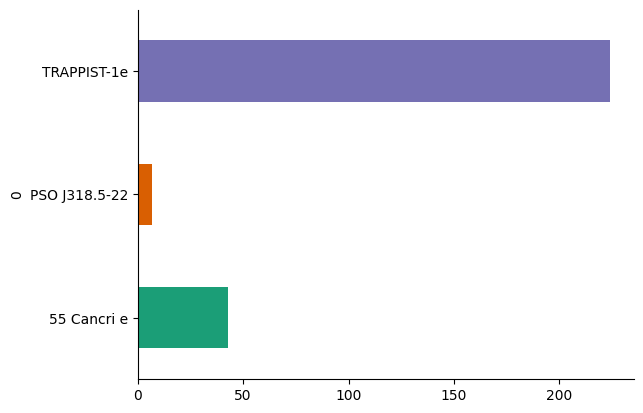

In [ ]:

dest_df.groupby(0).size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
null_dest['Destination'] = decoded_labels
null_dest

<ipython-input-157-237a97adb6ba>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  null_dest['Destination'] = decoded_labels


,HomePlanet,CryoSleep,Destination,Age,VIP,CabinDeck,CabinSide,Group_size,Family_size,IsAlone,Luxury_exp,Regular_exp,Total_exp
47,Mars,True,TRAPPIST-1e,19.000000,False,F,P,2,7.0,False,0.0,0.0,0.0
128,Earth,False,TRAPPIST-1e,34.000000,False,E,P,2,6.0,False,771.0,22.0,793.0
139,Earth,False,TRAPPIST-1e,41.000000,False,F,P,1,6.0,True,607.0,0.0,607.0
347,Earth,False,TRAPPIST-1e,23.000000,False,G,P,1,5.0,True,720.0,0.0,720.0
430,Earth,True,TRAPPIST-1e,50.000000,False,G,S,1,6.0,True,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12851,Earth,True,TRAPPIST-1e,0.000000,False,F,S,3,4.0,False,0.0,0.0,0.0
12856,Earth,True,TRAPPIST-1e,23.000000,False,G,P,1,4.0,True,0.0,0.0,0.0
12889,Earth,False,TRAPPIST-1e,31.000000,False,G,P,1,8.0,True,198.0,0.0,198.0
12912,Europa,False,55 Cancri e,17.000000,False,C,P,4,4.0,False,2021.0,2045.0,4066.0


In [ ]:
datam['Destination'] = datam['Destination'].fillna(null_dest['Destination'])
datam.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,CabinNo.,CabinSide,Group,Group_size,Last_name,Family_size,IsAlone,Luxury_exp,Regular_exp,Total_exp
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,0,P,0001,1,Ofracculy,3.0,True,0.0,0.0,0.0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,0,S,0002,1,Vines,4.0,True,702.0,34.0,736.0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,0,S,0003,2,Susent,7.0,False,6807.0,3576.0,10383.0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,0,S,0003,2,Susent,7.0,False,3522.0,1654.0,5176.0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,1,S,0004,1,Santantines,9.0,True,870.0,221.0,1091.0


In [ ]:
datam.isnull().sum().sort_values(ascending=False)

CabinSide       299
Cabin           299
CabinNo.        299
CabinDeck       299
VIP             296
Name            294
Last_name       294
Family_size     294
Age             270
FoodCourt       171
Spa             164
RoomService     162
ShoppingMall    161
VRDeck          149
IsAlone           0
Luxury_exp        0
Regular_exp       0
PassengerId       0
Group_size        0
Group             0
HomePlanet        0
Destination       0
CryoSleep         0
Total_exp         0
dtype: int64

In [ ]:
datam.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,CabinNo.,CabinSide,Group,Group_size,Last_name,Family_size,IsAlone,Luxury_exp,Regular_exp,Total_exp
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,0,P,0001,1,Ofracculy,3.0,True,0.0,0.0,0.0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,0,S,0002,1,Vines,4.0,True,702.0,34.0,736.0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,0,S,0003,2,Susent,7.0,False,6807.0,3576.0,10383.0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,0,S,0003,2,Susent,7.0,False,3522.0,1654.0,5176.0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,1,S,0004,1,Santantines,9.0,True,870.0,221.0,1091.0


In [ ]:
missing_categorical_columns = datam.select_dtypes(include=['object','bool']).isna().sum() > 0
missing_categorical_columns = list(missing_categorical_columns[missing_categorical_columns].index)


print(f'imputed columns: {missing_categorical_columns}')

for col in missing_categorical_columns:
    datam[col] = datam[col].fillna(data[col].mode()[0])

imputed columns: ['Cabin', 'VIP', 'Name', 'CabinDeck', 'CabinNo.', 'CabinSide', 'Last_name']


In [ ]:
missing_numerical_columns = datam.select_dtypes(include=['int','float64']).isna().sum() > 0
missing_numerical_columns = list(missing_numerical_columns[missing_numerical_columns].index)

print(f'imputed columns: {missing_numerical_columns}')

for col in missing_numerical_columns:
    datam[col] = datam[col].fillna(datam[col].mean())

imputed columns: ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Family_size']


In [ ]:
datam.to_csv('/content/drive/MyDrive/Data Analytics Boot Camp/Project_4/updated2.csv', index=False)

In [ ]:
model.save('/content/drive/MyDrive/Data Analytics Boot Camp/Project_4/cryosleep', save_format="h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model2.save('/content/drive/MyDrive/Data Analytics Boot Camp/Project_4/destination', save_format="h5")